#Video Game Sales with Ratings
*Cas kaggle*

Gerard Benet Martínez - 1704125
Javier Emparan López - 1704634

---

## Definició del problema

Aquest projecte se centra en l'anàlisi predictiva de l'èxit comercial de videojocs, utilitzant una base de dades que integra una àmplia col·lecció de títols amb les seves mètriques de qualitat extretes principalment de la plataforma Metacritic.

- S'analitzaran les dades i s'aplicara els diferents tractaments de preprocesat.
- Es comprobaran les distintes metriques pels models de regresió i trobar el ideal pel nostre cas
- S'entrenaran distints models i es seleccionar el que doni millors resultats.

---



In [10]:
#importacio de llibreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, f1_score, accuracy_score, precision_recall_curve, auc, roc_curve, classification_report

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import kagglehub


In [11]:

# Importacio de les dades directament de Kaggle
path = kagglehub.dataset_download("rush4ratio/video-game-sales-with-ratings")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/Video_Games_Sales_as_at_22_Dec_2016.csv")
print(df.head())

#inicialitzacio de dades importants
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Rating', 'Developer','Publisher', 'Genre']

Using Colab cache for faster access to the 'video-game-sales-with-ratings' dataset.
Path to dataset files: /kaggle/input/video-game-sales-with-ratings
                       Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77

## Visualització de les dades
En aquesta primera part fem una visualització inicial de les dades per a tenir una millor comprensió del problema i saber com afrontar-lo apropiadament.

In [12]:
#Funcions de visualització de dades
#Mostrar quantitat de NaNs
def mostrarGraficNaNs(dades):
  nan_counts_all = dades.isnull().sum()

  if not nan_counts_all.empty:
      plt.figure(figsize=(12, 6))

      nan_counts_all.plot(kind='bar', color='darkorange')

      plt.title('Quantitat de missing Values (NaN) per atribut', fontsize=16)
      plt.xlabel('Atributs', fontsize=12)
      plt.ylabel('Quantitat de NaNs', fontsize=12)

      for i, v in enumerate(nan_counts_all):
          plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

      plt.xticks(rotation=45, ha='right')
      plt.grid(axis='y', linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


In [13]:
print("Nombre d'atributs:", len(df.columns))
print(df.describe())
print(df.info())

Nombre d'atributs: 16
       Year_of_Release      NA_Sales      EU_Sales      JP_Sales  \
count     16450.000000  16719.000000  16719.000000  16719.000000   
mean       2006.487356      0.263330      0.145025      0.077602   
std           5.878995      0.813514      0.503283      0.308818   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2020.000000     41.360000     28.960000     10.220000   

        Other_Sales  Global_Sales  Critic_Score  Critic_Count    User_Count  
count  16719.000000  16719.000000   8137.000000   8137.000000   7590.000000  
mean       0.047332      0.533543     68.967679     26.360821    162.229908  
std        0.186710      1.547935     13.938165     18.980495    561.282326  
min        0.000000      0.010000     13.000000      

Per una part, podem veure que hi ha tant dades categoriques com dades no categoriques.
- Per la part de dades categoriques estan la plataforma on s'ha publicat el joc (platform), el genere del joc, el publisher, la desenvolupadora i el rating. També podem veure que el user_score no surt com a numeric, pero per que hi ha valors "tbd", els cuals haurem de tractar mes endavant.

- Per la part de dades no categoriques trobem l'any de publicació del joc, les ventes tant en NA, EU, JP, globals i altres, els tipus de valoració que hi ha, tant per la part de critics com d'usuari.

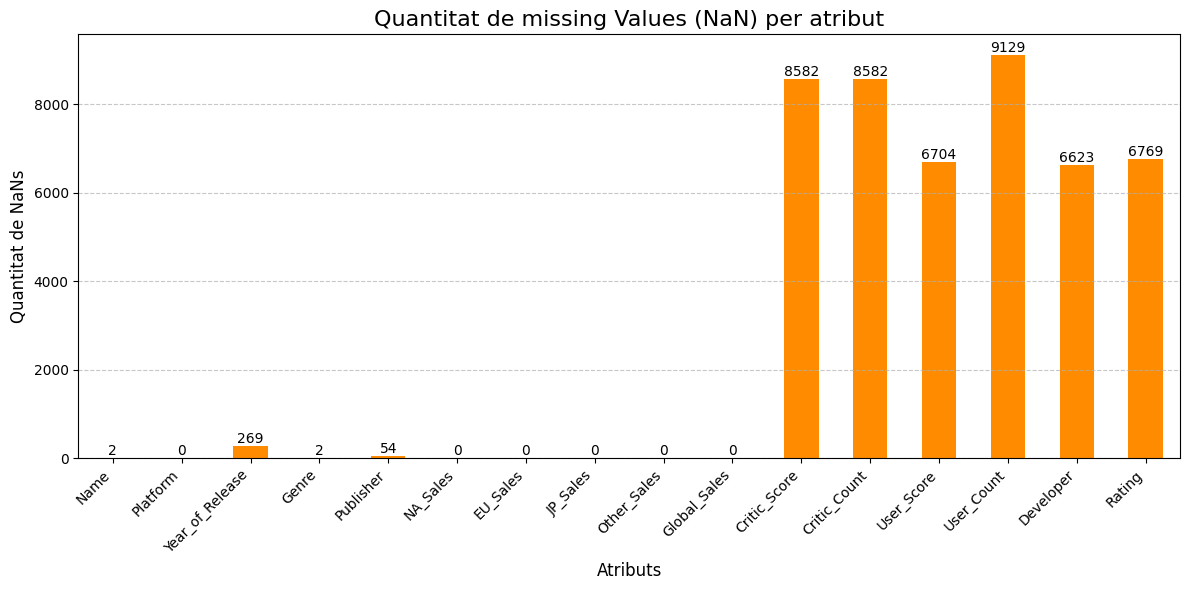

In [14]:
mostrarGraficNaNs(df)

Podem destacar que hi ha una gran quantitat de NaNs en les categories de valoracions (critic/user score i critic/user count), a més de la categoria Developer i rating. També podem veure una petita quantitat de NaNs en l'any de publicació i el publisher del joc.

Per la gran quantita de NaNs que hi ha, no podem optar a eliminar-los completament, ja que aixó reduiria la quantitat de dades drasticament, per tant, optarem per omplir-los.


---
## Preprocessament de dades


---
### Tractament de NaNs

Per una part, com hem vist a la part de visualització de dades, la columna "User_Score" es considerada categorica ja que conté dades "to be determined". Aquestes dades les tractarem com NaNs per poder tractarles mes endavant correctament amb la resta de missing values.

Una vegada tractats els "tbd" podem veure que la puntuació i la cuantitat de valoracions de user/crits encaixen.

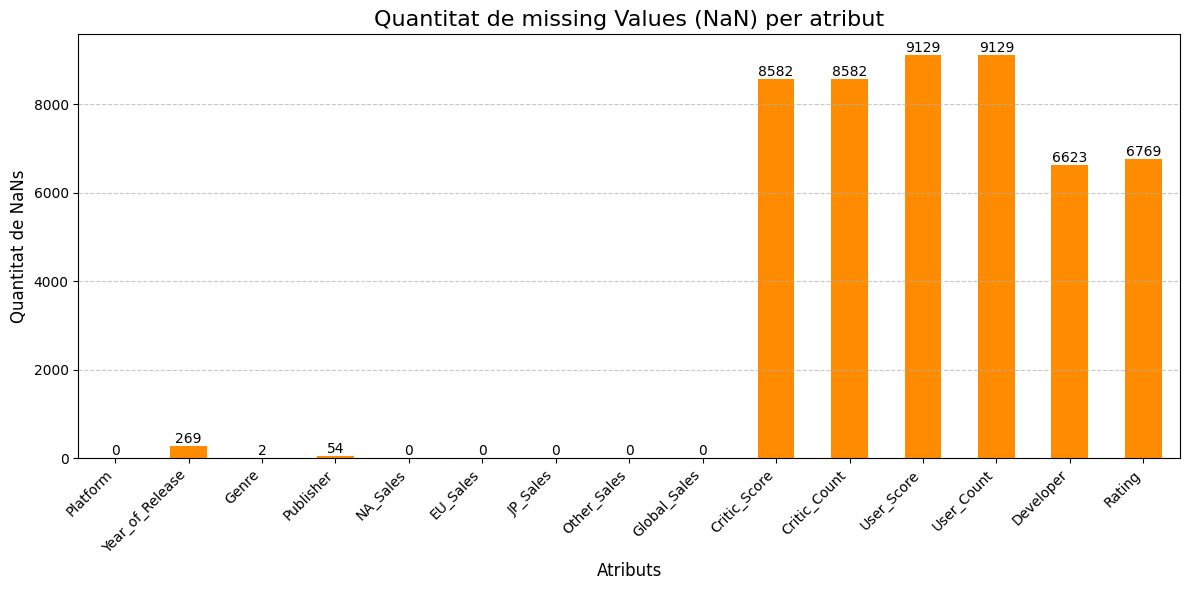

In [15]:
df['User_Score'] = df['User_Score'].replace('tbd', np.nan) #En la columna user score hay tbd. Esto transforma esos en NaNs
df['User_Score'] = pd.to_numeric(df['User_Score']) #Pasarlo a float64 y tal
df_noTbd = df.drop(columns=['Name'])
mostrarGraficNaNs(df_noTbd)


Una vegada fet aixó, podem començar a procesar els NaNs. Hem decidit utilitzar un SimplerImputer, on per omplir els valors numerics utilitzarem  la mediana i per les categoriques utilitzarem la moda.



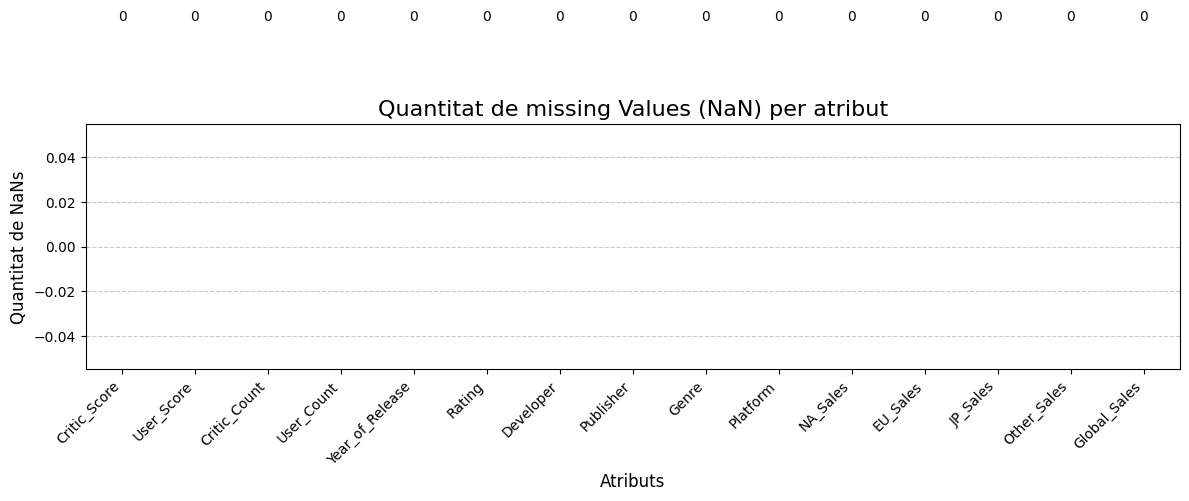

In [16]:
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Rating', 'Developer','Publisher', 'Genre']

#transformers per dades numeriques i categoriques
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


df_pre_imputed = preprocessor.fit_transform(df_noTbd)

columnas_procesadas = numeric_features + categorical_features
columnas_passthrough = [col for col in df_noTbd.columns if col not in columnas_procesadas]
columnas_resultado_completo = numeric_features + categorical_features + columnas_passthrough

df_imputed = pd.DataFrame(
    df_pre_imputed,
    columns=columnas_resultado_completo,
    index=df_noTbd.index
)

mostrarGraficNaNs(df_imputed)


---
### Data scaling

Per evitar el biaix de caracteristiques i millorar la convergencia mes endavant quan començem a entrenar els models, probarem diferents scalers. (explicar)

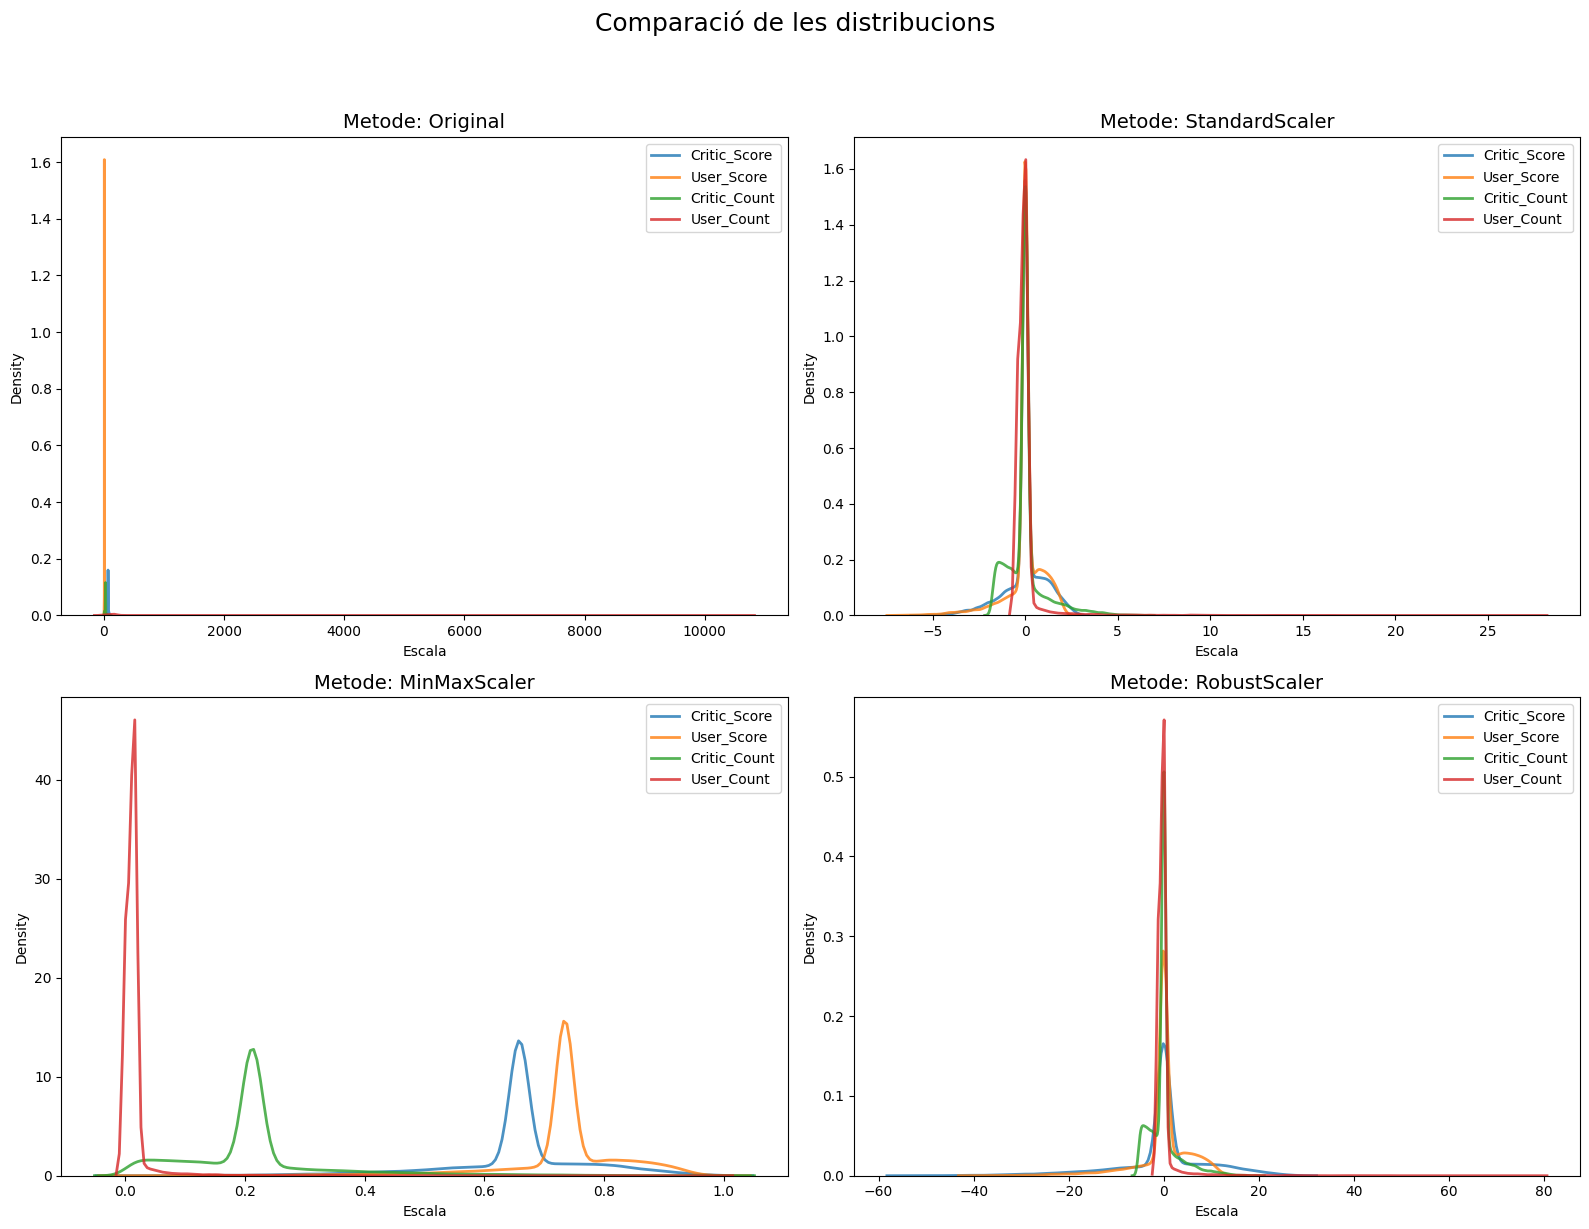

In [17]:
df_numeric_data = df_imputed[numeric_features]

scalers = {
    "Original": df_numeric_data.copy(),
    "StandardScaler": pd.DataFrame(
    StandardScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "MinMaxScaler": pd.DataFrame(
    MinMaxScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "RobustScaler": pd.DataFrame(
    RobustScaler().fit_transform(df_numeric_data), columns=numeric_features)}

plot_cols = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count']

plt.figure(figsize=(16, 12))
plt.suptitle('Comparació de les distribucions', fontsize=18, y=1.02)

for i, (name, scaled) in enumerate(scalers.items(), 1):
    plt.subplot(2, 2, i)
    for col in plot_cols:
         sns.kdeplot(scaled[col], fill=False, label=col, alpha=0.8, linewidth=2)

    plt.title(f'Metode: {name}', fontsize=14)
    plt.xlabel('Escala')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

---
### Tractament de dades categóriques


Per altra banda, també hem de tractar els atributs categorics previament mencionats. Aquest els transformarem amb un labelEncoder (o one hot encoder o lo q surja, si llegamos a usarlos).

In [18]:
categorical_cols = categorical_features

---
## Selecció de mètriques
Una vegada preprocesades les dades, seleccionem la millor mètrica pel problema

MSE, RMSE,R^2


---
## Selecció del model
Una vegada seleccionada la millor mètrica, seleccionarem el millor model pel problema

---
## Anàlisis final
